
https://www.programmersought.com/article/79718271604/



In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
#val_batch_size = 1

min_frame_count = 23

resume = False # Сохранённая модель или с нуля?
lr = 0.001
momentum = 0.001
epoches = 15
save = True


In [19]:
import os
from random import shuffle
from torchvision import transforms
import cv2
from torch.utils.data import Dataset
import torch
from uuid import uuid1
import torch
import torch.nn as nn
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from random import sample
import torchvision

import matplotlib.pyplot as plt

In [20]:
classes = (
    'пингвин','жираф', 'лягушка', 'бегемот', 'козел',
    'лиса', 'динозавр', 'кролик', 'собака', 'обезьяна',
    'корова', 'свинья', 'медуза', 'курица', 'павлин',
    'дельфин', 'слон', 'медведь', 'лебедь', 'орел',
    'бык', 'змея', 'птица', 'лось', 'пчела',
    'лев', 'тигр', 'мышь', 'паук', 'бабочка'
)
n_class = len(classes)

In [21]:
classes.index('динозавр')

6

In [22]:
class VideoDataset(Dataset):
    def __init__(self, dirs, min_frame_count):
        super(VideoDataset, self).__init__()
        self.base_dir = dirs
        self.min_frame_count = min_frame_count
        self.video_data=[]
        self.video_label=[]
        videos = []
        for word in os.listdir(self.base_dir):
          for video in os.listdir(os.path.join(self.base_dir, word)):
            videos.append(os.path.join(self.base_dir, word, video))

        '''
                 Read data, IT Will Take A Long Time
        '''
        for i,video_line in enumerate(videos):
            frames = self.get_video_and_label(video_line)
            label = classes.index(video_line.split("/")[-2])
            self.video_data.append(frames)
            self.video_label.append(label)



    def __getitem__(self, index):

        frames= self.video_data[index]
        label=self.video_label[index]
        frames=torch.Tensor(frames)
        frames=frames.permute(3,0,1,2)
        for frame in frames:
            frame.div_(127.5).sub_(1)

        return frames, label


    def __len__(self):
        return len(self.video_label)

    def get_video_and_label(self, video):
        frames_names = sorted(sample(os.listdir(video), self.min_frame_count),  key=lambda x: int(x.split('_')[-1][:-4]))
        frames = []
        for frame_name in frames_names:
          frame = cv2.imread(video + '/' + frame_name)
          frames.append(frame)
        return frames

In [23]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(device)

cuda


In [24]:
# Create data loaders

train_dir = "/content/drive/MyDrive/slovo/animalsdataset/train/"
test_dir = "/content/drive/MyDrive/slovo/animalsdataset/test/"
#val_dir = "/content/drive/MyDrive/slovo/animalsdataset/val/"

train_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
test_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
#val_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

train_dataloader = DataLoader(VideoDataset(train_dir, min_frame_count), batch_size=train_batch_size, shuffle=True, **train_kwargs)
test_dataloader = DataLoader(VideoDataset(test_dir, min_frame_count), batch_size=test_batch_size, shuffle=True, **test_kwargs)
#val_dataloader = DataLoader(VideoDataset(val_dir, min_frame_count), batch_size=val_batch_size, shuffle=True, **val_kwargs)

In [25]:
frames, labels = next(iter(test_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, channels, frames, w, h)
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

<ipython-input-22-7385b880bc14>:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  frames=torch.Tensor(frames)


Frames shape: torch.Size([1, 3, 23, 224, 224])
Labels shape: torch.Size([1])
Labels: tensor([13])


In [26]:
#frames[0].shape
frames[0].permute(1,0,2,3).shape

torch.Size([23, 3, 224, 224])

слон
torch.Size([23, 3, 224, 224])


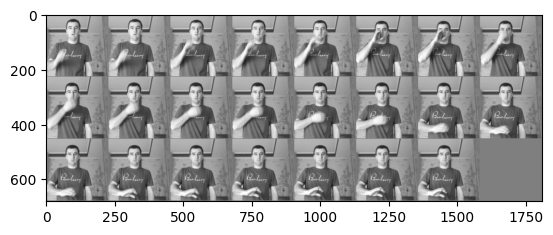

козел
torch.Size([23, 3, 224, 224])


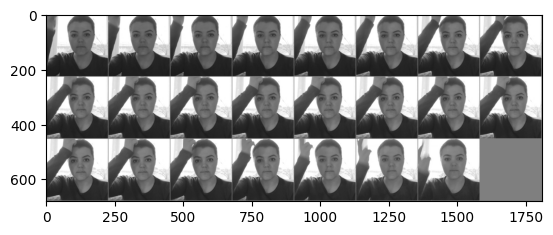

дельфин
torch.Size([23, 3, 224, 224])


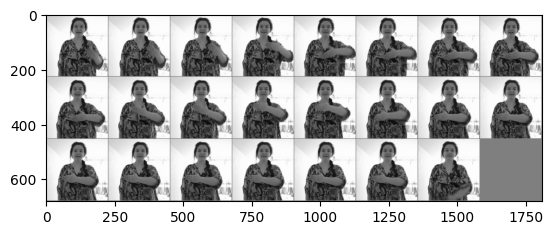

In [27]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

test_dl = iter(test_dataloader)
for i in range(3):
  frames, labels = next(test_dl)
  print(classes[labels.item()])
  frames = frames[0].permute(1,0,2,3)
  print(frames.shape)
  imshow(torchvision.utils.make_grid(frames))

In [ ]:
class C3D(nn.Module):
    """
    The C3D network.
    """

    def __init__(self, num_classes):
        super(C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(32768, 512) #8192
        self.fc7 = nn.Linear(512, 100)
        self.fc8 = nn.Linear(100, num_classes)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

        self.sigmoid=nn.Sigmoid()




    def forward(self, x):
        #print ('1:',x.size())
        x = self.relu(self.conv1(x))
        #print ('2:',x.size())
        x = self.pool1(x)
        #print ('3:',x.size())

        x = self.relu(self.conv2(x))
        #print ('4:',x.size())
        x = self.pool2(x)
        #print ('5:',x.size())

        x = self.relu(self.conv3a(x))
        #print ('6:',x.size())
        x = self.relu(self.conv3b(x))
        #print ('7:',x.size())
        x = self.pool3(x)
        #print ('8:',x.size())

        x = self.relu(self.conv4a(x))
        #print ('9:',x.size())
        x = self.relu(self.conv4b(x))
        #print ('10:',x.size())
        x = self.pool4(x)
        #print ('11:',x.size())

        x = self.relu(self.conv5a(x))
        #print ('12:',x.size())
        x = self.relu(self.conv5b(x))
        #print ('13:',x.size())
        x = self.pool5(x)
        #print ('14:',x.size())

        x = x.view(-1, 512* 1* 8* 8 ) # 8192
        #print ('15:',x.size())
        x = self.relu(self.fc6(x))
        #print ('16:',x.size())
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)
        #print ('17:',logits.size())
        return logits

In [29]:
if resume:
  try:
    model_path = '/content/drive/MyDrive/slovo/weights/3DCNN-Epoch-1-Test_acc-0.03333333507180214.pth'
    print("Load the weight from pretrained-weight file")
    model = C3D(num_classes=n_class).to(device)
    model_dict = torch.load(model_path, map_location=torch.device(device))
    model_dict = {k.replace('module.', ''):v for k, v in model_dict['model_state_dict'].items()}
    model.load_state_dict(model_dict)
    model.eval()
    previous_epochs = int(model_path.split('/')[-1].split('-')[2])
    best_acc = float(int(model_path.split('/')[-1].split('-')[2].split('.')[0]))
    # model_dict = model['model_state_dict']
    # # pretrained_dict = {k: v for k, v in pretrained_dict.items() if np.shape(model_dict[k]) == np.shape(v)}
    # # model_dict.update(pretrained_dict)
    #
    # model.load_state_dict(model_dict)
    print("Finished to load the weight")
  except:
    print("Can not load weight \n train the model from stratch")
    raise
else:
  model = C3D(num_classes=n_class).to(device)
  previous_epochs = 0
  best_acc = 0

In [32]:
frames, labels = next(iter(test_dataloader))
frames = frames.to(device)
print(f"Output shape: {model(frames).shape}") # batch size, number of classes

Output shape: torch.Size([1, 30])


In [33]:
#Constructing LOSS target functions. Select an optimizer. Learning rate change
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)

In [34]:
def check_some_predictions(n):
  test_dl = iter(test_dataloader)
  for i in range(n):
    frames, labels = next(test_dl)
    frames=frames.to(device)
    true_label = classes[labels.item()]
    output = model(frames)
    pred_label = classes[torch.argmax(output, 1)]
    print(f"Label: {true_label}; Predicted: {pred_label}")
check_some_predictions(5)

Label: лебедь; Predicted: обезьяна
Label: орел; Predicted: обезьяна
Label: бык; Predicted: змея
Label: лев; Predicted: змея
Label: птица; Predicted: обезьяна


In [35]:
def train(epoch):
  total_loss = []
  pbar = tqdm(train_dataloader, desc=f'Train Epoch{epoch}/{epoches}')
  for data, target in pbar:
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()  # Model Parameters Gradient Clear
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    total_loss.append(loss.item())
    pbar.set_description(f'Train Epoch:{epoch}/{epoches} train_loss:{round(np.mean(total_loss), 4)}')
    #scheduler.step()

In [41]:
def test(epoch):
  global best_acc
  test_loss = []
  correct=0
  total=0
  model.eval()
  pbar = tqdm(test_dataloader, desc=f'Test Epoch{epoch}/{epoches}', mininterval=0.3)
  for data, target in pbar:
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
      output = model(data)
    loss = criterion(output, target)
    test_loss.append(loss)
    pred = torch.argmax(output, 1)
    correct += (pred == target.item()).sum().float()
    total += len(target)
    predict_acc = correct / total
    pbar.set_description(f'Test Epoch:{epoch}/{epoches} acc:{predict_acc:.3f}')
  if save: # and predict_acc > best_acc:
    best_acc = predict_acc if predict_acc > best_acc else best_acc
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                #'loss': round(np.mean(test_loss), 2)
            },
                "/content/drive/MyDrive/slovo/weights" + f'/3DCNN-Epoch-{epoch}-Test_acc-{predict_acc:.3f}.pth')
  check_some_predictions(5)


In [1]:
if use_cuda:
  model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

for epoch in range(previous_epochs+1, previous_epochs + epoches + 1):
  train(epoch)
  if epoch % 1 == 0:
    test(epoch)

NameError: ignored

In [ ]:
torch.save({
                'epoch': 3,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': round(np.mean(test_loss), 2)
            },
                "/content/drive/MyDrive/slovo/weights" + f'/3DCNN-Epoch-{epoch}-Test_acc-{0.33:.3f}.pth')